# Kiter Performance Analysis

This Jupyter notebook can be used to generate and analyse Kiter's K-Periodic throughput analysis technique.
Kiter is is C++ program, in this notebook we will run Kiter using the bash interface of Jupyter (tested on Linux only).

Warning: make sure you open this notebook from the root of kiter : `jupyter notebook tools/processOutput.ipynb`

## Tests and Imports

In [9]:
KITER="../Release/bin/kiter"
BENCHDIR= "../benchmarks/sdf3bench/"
LOGDIR="/tmp/sdf3_kperiodic/"

import os 
assert(os.path.exists(KITER))
assert(os.path.exists(BENCHDIR))

In [10]:
import matplotlib.pyplot as plt
import numpy as np 
import matplotlib.style
import matplotlib as mpl
import seaborn as sns
sns.set()

## Data generation

First we generate the data by running kiter KPeriodicThroughput over the SDF3 dataset.

In [30]:
%%bash -s "$KITER" "$BENCHDIR" "$LOGDIR"

KITER=$1
BENCHDIR=$2
LOGDIR=$3

if [ ! -x $KITER ] ; then echo "Kiter not found" ; exit 1 ; fi
if [ ! -x $BENCHDIR ] ; then echo "Benchmark not found" ;exit 1 ; fi
if [ -x $LOGDIR ] ; then 
    echo "Log dir already exists" ;
    rm ${LOGDIR}/*.csv || true;
else
    mkdir -p ${LOGDIR};
fi

echo "Start benchmarking..."


for category in one two three four ; do
    for f in $BENCHDIR/${category}_* ; do 
        TARGET_FILE=`basename "${f}"`
        $KITER -f $f -a KPeriodicThroughput -pDETAILS=1 >> ${LOGDIR}/${TARGET_FILE}.csv
    done
done

ls ${LOGDIR}/* 2> /dev/null | head 
cat ${LOGDIR}/four_graph.0.xml.csv

Log dir already exists
Start benchmarking...
/tmp/sdf3_kperiodic//four_graph.0.xml.csv
/tmp/sdf3_kperiodic//four_graph.10.xml.csv
/tmp/sdf3_kperiodic//four_graph.11.xml.csv
/tmp/sdf3_kperiodic//four_graph.12.xml.csv
/tmp/sdf3_kperiodic//four_graph.13.xml.csv
/tmp/sdf3_kperiodic//four_graph.14.xml.csv
/tmp/sdf3_kperiodic//four_graph.15.xml.csv
/tmp/sdf3_kperiodic//four_graph.16.xml.csv
/tmp/sdf3_kperiodic//four_graph.17.xml.csv
/tmp/sdf3_kperiodic//four_graph.18.xml.csv
filename;task_count;buffer_count;iteration;gduration;hduration;duration;sum_Ki;sum_KiKj;sum_Ni;sum_NiNj;th
../benchmarks/sdf3bench//four_graph.0.xml;15;25;0;9.9212e-05;3.4396e-05;0.000133608;15;40;235;591;1.388888889e-02


## Load the Raw Data

In [31]:
import glob
import pandas as pd
all_df = []

for f in glob.iglob(LOGDIR + '/*.xml.csv'):
    tmp = pd.read_csv(f, sep=";")
    all_df.append(tmp)

raw_df = pd.concat(all_df, axis=0, ignore_index=True)

In [32]:
raw_df.head(5)

,filename,task_count,buffer_count,iteration,gduration,hduration,duration,sum_Ki,sum_KiKj,sum_Ni,sum_NiNj,th
0,../benchmarks/sdf3bench//four_graph.9.xml,10,14,0,0.000064,0.000021,0.000085,10,24,7199,15956,0.000208
1,../benchmarks/sdf3bench//four_graph.99.xml,15,26,0,0.000089,0.000025,0.000115,15,41,208751,446422,0.000009
2,../benchmarks/sdf3bench//four_graph.98.xml,14,23,0,0.000079,0.000024,0.000103,14,37,1571,3983,0.000833
3,../benchmarks/sdf3bench//four_graph.97.xml,14,24,0,0.000080,0.000022,0.000102,14,38,503,1098,0.003333
4,../benchmarks/sdf3bench//four_graph.96.xml,14,21,0,0.000080,0.000019,0.000100,14,35,2233,3926,0.001250


## Wrangle the data

### Build the per Iteration DataFrame

In [33]:
iter_df = raw_df.copy()

In [34]:
## Complexity
iter_df ["complexityV"] = iter_df ["sum_Ki"]  / iter_df ["sum_Ni"]
iter_df ["complexityE"] = iter_df ["sum_KiKj"]  / iter_df ["sum_NiNj"]
iter_df ["sum_KiKj2"]   = iter_df ["sum_KiKj"]  * iter_df ["sum_KiKj"]

In [35]:
## ADD MAX THROUGHPUT
max_th_per_filename = iter_df.groupby("filename", as_index=False).max()[["filename","th","complexityV"]].rename({"th":"maxth", "complexityV":"maxComplexityV"}, axis='columns')
sum_dur_per_filename = iter_df.groupby("filename", as_index=False).sum()[["filename","duration"]].rename({"duration":"total_duration"}, axis='columns')
cnt_dur_per_filename = iter_df.groupby("filename", as_index=False).count()[["filename","iteration"]].rename({"iteration":"total_iteration"}, axis='columns')

iter_df = pd.merge(iter_df,max_th_per_filename, left_on='filename', right_on = "filename")
iter_df = pd.merge(iter_df,sum_dur_per_filename, left_on='filename', right_on = "filename")
iter_df = pd.merge(iter_df,cnt_dur_per_filename, left_on='filename', right_on = "filename")

In [36]:
## FIX THROUGHPUT TO ZERO
iter_df ["th"] = iter_df ["th"].apply(lambda x : max(x,0))

In [37]:
## VARIOUS VARIABLES
iter_df ["optimality"] = (iter_df ["th"]  / iter_df ["maxth"]).apply(lambda x : max(x,0))
iter_df ["HSDF"] = (iter_df ["task_count"]  == iter_df ["sum_Ni"])

In [38]:
## Find category
from sklearn import preprocessing

iter_df["categoryStr"] = iter_df["filename"].apply(lambda x : x.split("/")[-1].split("_")[0])

le = preprocessing.LabelEncoder()
le.fit(iter_df['categoryStr'])
iter_df['category'] = le.transform(iter_df['categoryStr'])

In [39]:
iter_df["difficult"]  = iter_df["total_iteration"] > 1

In [40]:
iter_df.head(2)

,filename,task_count,buffer_count,iteration,gduration,hduration,duration,sum_Ki,sum_KiKj,sum_Ni,...,sum_KiKj2,maxth,maxComplexityV,total_duration,total_iteration,optimality,HSDF,categoryStr,category,difficult
0,../benchmarks/sdf3bench//four_graph.9.xml,10,14,0,0.000064,0.000021,0.000085,10,24,7199,...,576,0.000208,0.001389,0.000085,1,1.0,False,four,0,False
1,../benchmarks/sdf3bench//four_graph.99.xml,15,26,0,0.000089,0.000025,0.000115,15,41,208751,...,1681,0.000009,0.000072,0.000115,1,1.0,False,four,0,False


### Build per graph Dataframe

In [41]:
sumdf = iter_df.groupby("filename", as_index=False).sum()[["filename","duration"]]
maxdf = iter_df.groupby("filename", as_index=False).max()[["filename","th","complexityV","sum_Ki","sum_KiKj",'sum_Ni',"task_count","buffer_count"]]
cntdf = iter_df.groupby("filename", as_index=False).count()[["filename","iteration"]]

tmp = pd.merge(sumdf,maxdf, left_on='filename', right_on = "filename")
graph_df = pd.merge(tmp,cntdf, left_on='filename', right_on = "filename")

graph_df["categoryStr"] = graph_df["filename"].apply(lambda x : x.split("/")[-1].split("_")[0])
graph_df.describe()

,duration,th,complexityV,sum_Ki,sum_KiKj,sum_Ni,task_count,buffer_count,iteration
count,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000
mean,0.001283,0.004873,0.448211,138.593443,306.239344,3133.619672,104.072131,133.252459,1.252459
std,0.009794,0.012531,0.471929,295.136295,602.324394,14205.155231,125.980345,158.722610,0.737975
min,0.000043,0.000009,0.000072,3.000000,6.000000,3.000000,3.000000,3.000000,1.000000
25%,0.000108,0.000196,0.008587,15.000000,39.000000,282.000000,15.000000,23.000000,1.000000
50%,0.000144,0.000667,0.071642,25.000000,55.000000,376.000000,22.000000,28.000000,1.000000
75%,0.001570,0.004630,1.000000,278.000000,621.000000,1809.000000,274.000000,342.000000,1.000000
max,0.171167,0.166667,1.000000,4754.000000,9510.000000,208751.000000,300.000000,394.000000,5.000000


## Analysis the data 

### Graph generation duration VS Howard duration

What takes the most time, producing the graph, compare `gduration` and `hduration`:

In [42]:
iter_df[["gduration", "hduration"]].mean()

gduration    0.000908
hduration    0.000116
dtype: float64

## Data cleaning 

Removing weird points : 

In [43]:
iter_df[iter_df["duration"] > 0.4 ] ## ./sdf3bench/one_h263decoder_buffer.xml
iter_df[iter_df["filename"] == "./sdf3bench/one_h263decoder_buffer.xml"]

clean_iter_df = iter_df[iter_df["filename"] != "./sdf3bench/one_h263decoder_buffer.xml"]
clean_iter_df = clean_iter_df[clean_iter_df["duration"] < 0.4 ] 

## Data visualization



We can look at the distribution of iteration:

In [44]:
sections = [0.2,0.5,0.8]

def section_by(df, sections,columnName) :

    sec_df   = {}
    start = 0
    for s in sections :
        label=str(start) + ' - ' + str(s)
        tmp = df if (start == 0) else df [ df  [columnName] > start ] 
        sec_df[label] = tmp [ tmp  [columnName] < s ]
        start = s
    label=str(start) + ' - 1'
    sec_df[label] = df [ df  [columnName] > start ] 
    return sec_df

In [45]:
def plot_iteration_distribution (ax,df,sections,title) :
    ax.set_xlabel("Total iterations required.")
    ax.set_ylabel("Density (#Apps)")

    colors = plt.get_cmap('gray',len(sections) + 2)((range(0,len(sections) + 1)))
    colors = list(colors)
    colors.reverse()
    sec_df = section_by (df , sections, "complexityV")
    max_iteration = df["iteration"].max()
    _ = ax.hist([x["iteration"] for x in sec_df.values()] , 
             bins=np.arange(1,max_iteration+3)-0.5, 
             stacked=True, color = colors,
             label=sec_df.keys())

    _ = ax.set_xticks(range(1,max_iteration+3))
    _ = ax.set_title(title)
    _ = ax.legend(title = "Expansion ratio")
    
colors = plt.get_cmap('gray',len(sections) + 2)((range(0,len(sections) + 1)))
colors = list(colors)

/home/toky/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


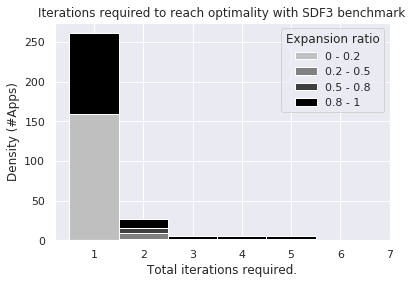

In [46]:
    
fig, ax = plt.subplots()
_ = plot_iteration_distribution (ax,graph_df,sections,"Iterations required to reach optimality with SDF3 benchmark") 


Most of the graph only need one iteration, let's separate the different type of graph

In [47]:
HSDF_group = graph_df[graph_df["sum_Ni"] == graph_df["task_count"]]
SDF_group = graph_df[graph_df["sum_Ni"] != graph_df["task_count"]]
SDF_group_simple = SDF_group [ SDF_group ["iteration"] == 1  ]
SDF_group_hard = SDF_group [ SDF_group ["iteration"] != 1  ]

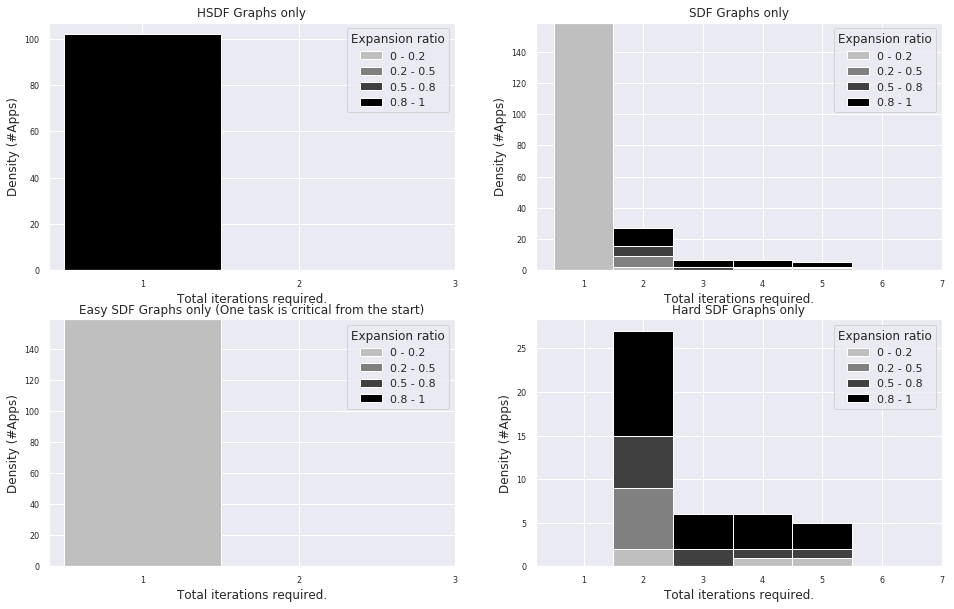

In [48]:


matplotlib.rc('xtick', labelsize=8) 
matplotlib.rc('ytick', labelsize=8) 

fig, axs = plt.subplots(2,2)
fig.set_size_inches(16, 10)
plot_iteration_distribution (axs[0,0],HSDF_group,sections,"HSDF Graphs only") 
plot_iteration_distribution (axs[0,1],SDF_group,sections,"SDF Graphs only") 
plot_iteration_distribution (axs[1,0],SDF_group_simple,sections,"Easy SDF Graphs only (One task is critical from the start)") 
plot_iteration_distribution (axs[1,1],SDF_group_hard,sections,"Hard SDF Graphs only") 



Plot graph size against iteration execution time 

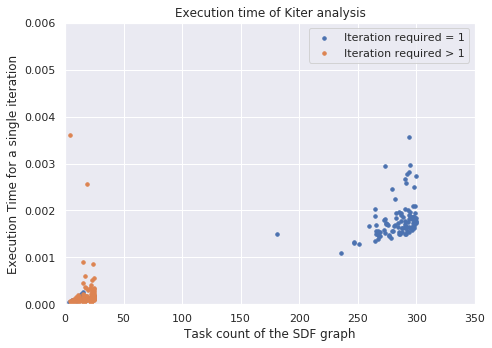

In [49]:
import matplotlib.pyplot as plt
import numpy as np 
import matplotlib.style
import matplotlib as mpl
import seaborn as sns
sns.set()

fig, ax = plt.subplots(1,1)
fig.set_size_inches(7, 5)

tmp = clean_iter_df
tmpE = tmp[tmp["difficult"] == False]
tmpH = tmp[tmp["difficult"] == True]


ax.set_title("Execution time of Kiter analysis")
ax.scatter(tmpE["task_count"], tmpE["duration"], s=12,  label = "Iteration required = 1")
ax.scatter(tmpH["task_count"], tmpH["duration"], s=12,  label = "Iteration required > 1")
ax.set_ylim(0,0.006)
ax.set_xlim(0,350)
ax.legend()
ax.set_ylabel('Execution Time for a single iteration')
ax.set_xlabel('Task count of the SDF graph')

#axs[2].set_title("General regression")
#sns.regplot(data=tmp, x='sum_KiKj2', y='duration',  fit_reg=True, ax=axs[1])
#for ax in axs :
#    _ = ax.set_ylabel('Execution Time of a single iteration')
#    _ = ax.set_xlabel('sum_KiKj2')
#    _ = ax.set_ylim(0,0.006)
#_ = axs.set_xlim(0,1000)


fig.tight_layout()


### GARDER THIS ONE  (3)

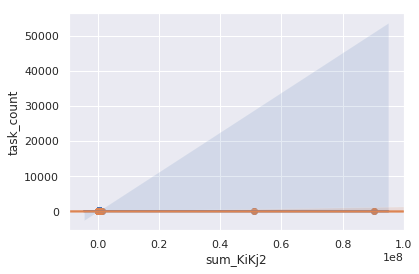

In [50]:
sns.regplot(data=clean_iter_df, x='sum_KiKj2', y='task_count',  fit_reg=True)
sns.regplot(data=clean_iter_df[clean_iter_df["difficult"] == True], x='sum_KiKj2', y='task_count',  fit_reg=True)

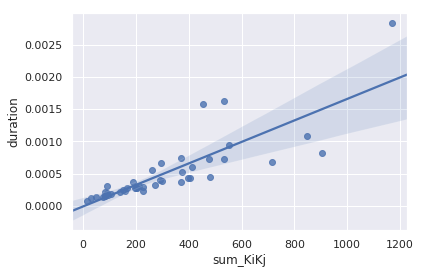

In [51]:
#sns.regplot(data=HSDF_group, x='sum_KiKj', y='task_count',  fit_reg=True)
#sns.regplot(data=SDF_group_simple, x='sum_KiKj', y='task_count',  fit_reg=True)
sns.regplot(data=SDF_group_hard[SDF_group_hard["sum_KiKj"] < 6000], x='sum_KiKj', y='duration',  fit_reg=True)


### GARDER THIS ONE  (6)

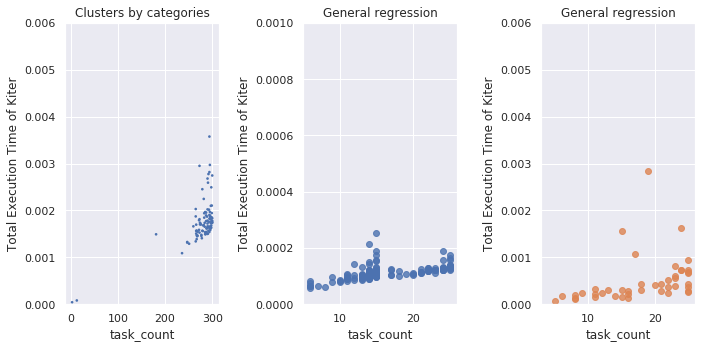

In [52]:
import matplotlib.pyplot as plt
import numpy as np 
import matplotlib.style
import matplotlib as mpl
import seaborn as sns
sns.set()

fig, axs = plt.subplots(1,3)
fig.set_size_inches(10, 5)

tmp = clean_iter_df[clean_iter_df["difficult"] == True]
tmp_SDF_group_simple = SDF_group_simple [ SDF_group_simple["duration"] < 0.002]

axs[0].set_title("Clusters by categories")
axs[0].scatter(HSDF_group["task_count"], HSDF_group["duration"], s=7, cmap=mpl.cm.brg, edgecolors='none')
axs[0].set_ylim(0,0.006)
axs[1].set_title("General regression")
sns.regplot(data=tmp_SDF_group_simple, x='task_count', y='duration',  fit_reg=False, ax=axs[1])
axs[1].set_ylim(0,0.001)
axs[2].set_title("General regression")
sns.regplot(data=SDF_group_hard, x='task_count', y='duration',  fit_reg=False, ax=axs[2])
axs[2].set_ylim(0,0.006)

for ax in axs :
    _ = ax.set_ylabel('Total Execution Time of Kiter')
    _ = ax.set_xlabel('task_count')

#_ = axs.set_xlim(0,1000)


fig.tight_layout()

Short time, small dataset, not much to say. 

(0, 118352550.23485899)

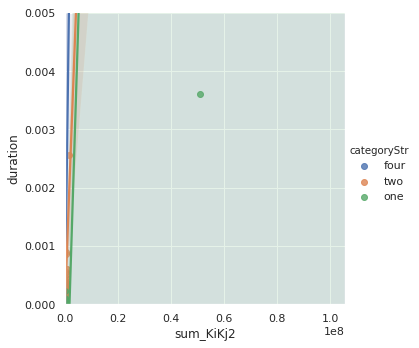

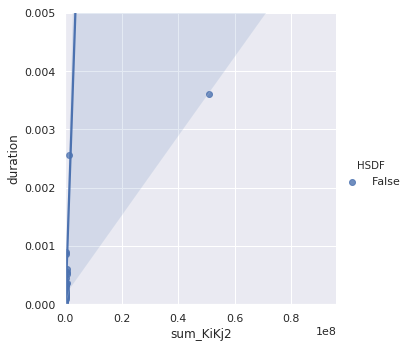

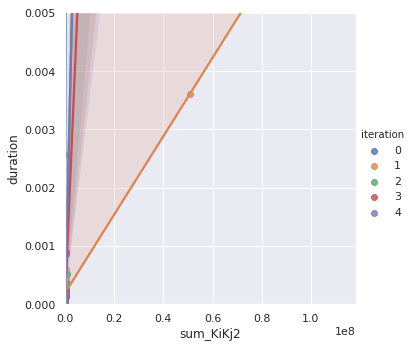

In [53]:
grid = sns.lmplot(data=tmp, x='sum_KiKj2', y='duration',  hue="categoryStr" ,fit_reg=True)

plt.ylim(0, 0.005)
plt.xlim(0, None)
grid = sns.lmplot(data=tmp, x='sum_KiKj2', y='duration',  hue="HSDF" ,fit_reg=True)

plt.ylim(0, 0.005)
plt.xlim(0, None)


grid = sns.lmplot(data=tmp, x='sum_KiKj2', y='duration',  hue="iteration" ,fit_reg=True)

plt.ylim(0, 0.005)
plt.xlim(0, None)

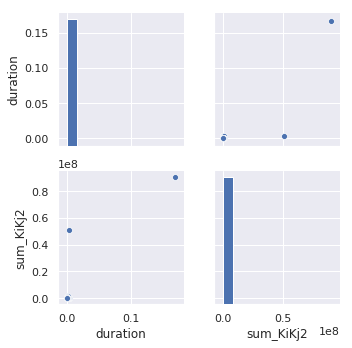

In [54]:
sns.pairplot(clean_iter_df [["duration", "sum_KiKj2"]])

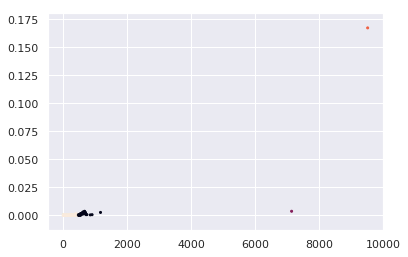

In [55]:
from matplotlib import pyplot as plt
import matplotlib as mpl


from sklearn.cluster import KMeans

tmp = clean_iter_df.copy()#[["sum_KiKj" , "duration"]]
tmp = tmp.drop(['filename'], axis=1)
tmp = tmp.drop(['categoryStr'], axis=1)
# Number of clusters
KMeansGen = KMeans(n_clusters=4)
# Fitting the input data
KmeanModel = KMeansGen.fit(tmp)
# Getting the cluster labels
clusters = KmeanModel.predict(tmp)
# Centroid values
kcenters = KmeanModel.cluster_centers_
plt.scatter(tmp["sum_KiKj"], tmp["duration"],s=4,c =clusters)


The data is as follow:

For every dataflow graph from the SDF3 dataset, we run the Exact throughput evaluation method as describe in Algorithm X. Given the nature of this algorithm we collect every K-periodic schedules required to reach optimality.

For each of these K-Periodic schedule we note two parameters, the optimality, and the complexity.

The optimality is how fast the current schedule is compared with the maximum throughput of the application. If we note Th* the exact throughput of G and ThK the current throughput, then OptimalityK = ThK/th*.

Simlarly the complexity is how complex is the current Kperiodic scedule compared with the biggest expansion known to be optimal. I we not Cn the sum of Ni, Ck = sum(Ki) / sum (Ni).

Both value comprise between 0 and 1 will be used to describe 

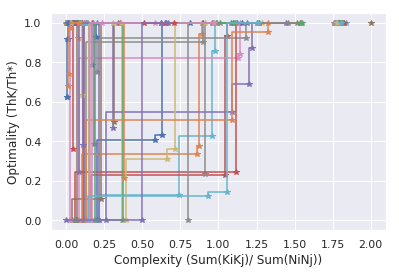

In [56]:
import seaborn as sns
sns.set()
tmp = clean_iter_df.copy()
fig, ax = plt.subplots()
ax.set_xlabel("Complexity (Sum(KiKj)/ Sum(NiNj))")
ax.set_ylabel("Optimality (ThK/Th*)")
for name in tmp["filename"].unique() :
    values = tmp[ tmp["filename"] == name  ][[ "complexityE", "optimality"]]
    plt.step(values[ "complexityE"], values[ "optimality"], marker="*")

In [57]:
import seaborn as sns
sns.set()


def plotIterationLines (ax,df,title) :
    ax.set_xlabel("Expansion ratio")
    ax.set_ylabel("Optimality")
    for name in df["filename"].unique() :
        values = df[ df["filename"] == name  ][[ "complexityV", "optimality"]]
        ax.step(values[ "complexityV"], values[ "optimality"], marker="*", c="grey")
        #print(name)
        #print(values)
    ax.set_title(title + " (" + str(len(df[df["iteration"] == 0])) +  " graphs)" )
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlim(-0.05, 1.05)
    
    

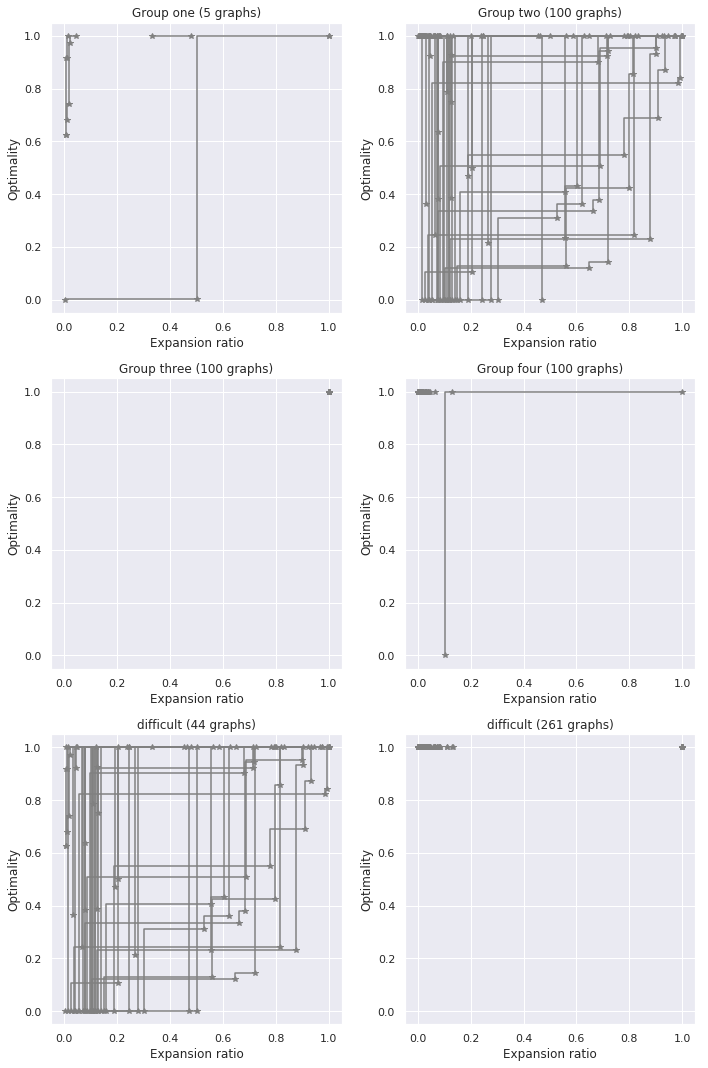

In [58]:
tmp = iter_df.copy()

    
fig, ax = plt.subplots(3,2)
fig.set_size_inches(10, 15)
plotIterationLines (ax[0,0],tmp[tmp["categoryStr"] == "one"],"Group one")
plotIterationLines (ax[0,1],tmp[tmp["categoryStr"] == "two"],"Group two")
plotIterationLines (ax[1,0],tmp[tmp["categoryStr"] == "three"],"Group three")
plotIterationLines (ax[1,1],tmp[tmp["categoryStr"] == "four"],"Group four")
plotIterationLines (ax[2,0],tmp[tmp["difficult"] == True],"difficult")
plotIterationLines (ax[2,1],tmp[tmp["difficult"] == False],"difficult")


fig.tight_layout()


### GARDER THIS ONE  (4)


In this graph, each line is a particular dataflow application from SDF3, and each dot for these lines is a Kperiodic schedule required in the Algorithm to reach optimality.
By nature, each line finish at the top of the graph, however they do not necessarily start from the bottom. 
In Fact, most line are only compose of one point directly at the top, of complexity minimal and already optimal. This happens when the optimality is reach by a simple 1-Perioic schedule. Some of the lines start in the middle of the graph, one can be seen halfway in hte middle of optimality with a complexity of 20%. And a thrid group of line doe start with an optimality of 0, meaning that the first schedule and possiblity the following did not probide a valid solution. 

In this graph we note three very important fact regarding the current SDF3 dataset. 

In [59]:
counted = iter_df.groupby("filename").count()
print("Number of Graph where optimality is reached the first round:", len(counted[ counted[ "sum_Ki" ] == 1]) ,"over" , len(counted))

Number of Graph where optimality is reached the first round: 261 over 305


First as previosuly noted, optimality can be reach in the first schedule, this is the case for more than 50% of this dataset, this means that even though most of these graph have the same size, there is a important disparity for us in term of complexity.

Second, for several of the most complex case, we can see entermidiate solutions this mean there is a potential to produce smaller schedules with a lower throughput.

Finally the distribution of the maximum complexity required to reach optimality. There is clearly two groups of application, these that reach otpimality within less than 20% of the final complexity and for which the algoritmh provide the best result, and other, more complex problem, where  80% or more of compleixty is reach.

Let's look more into details in this density. We will ignore the most simple case where Sum(Ni) = Number of task. 
To move forward with this result, let's look at figure X where instead of relative complexity we look at there absolute complexity (sum(Ni)).

In [60]:
optimals = iter_df [ iter_df["optimality"] == 1 ]
optimals = optimals [ optimals ["sum_Ni"] != optimals ["task_count"]  ]
#optimals = optimals [ optimals["index"] != 0]
optimals.head(5)

,filename,task_count,buffer_count,iteration,gduration,hduration,duration,sum_Ki,sum_KiKj,sum_Ni,...,sum_KiKj2,maxth,maxComplexityV,total_duration,total_iteration,optimality,HSDF,categoryStr,category,difficult
0,../benchmarks/sdf3bench//four_graph.9.xml,10,14,0,0.000064,0.000021,0.000085,10,24,7199,...,576,0.000208,0.001389,0.000085,1,1.0,False,four,0,False
1,../benchmarks/sdf3bench//four_graph.99.xml,15,26,0,0.000089,0.000025,0.000115,15,41,208751,...,1681,0.000009,0.000072,0.000115,1,1.0,False,four,0,False
2,../benchmarks/sdf3bench//four_graph.98.xml,14,23,0,0.000079,0.000024,0.000103,14,37,1571,...,1369,0.000833,0.008912,0.000103,1,1.0,False,four,0,False
3,../benchmarks/sdf3bench//four_graph.97.xml,14,24,0,0.000080,0.000022,0.000102,14,38,503,...,1444,0.003333,0.027833,0.000102,1,1.0,False,four,0,False
4,../benchmarks/sdf3bench//four_graph.96.xml,14,21,0,0.000080,0.000019,0.000100,14,35,2233,...,1225,0.001250,0.006270,0.000100,1,1.0,False,four,0,False


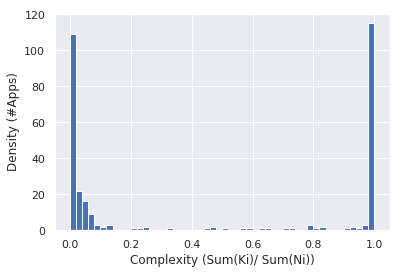

In [61]:
allend = iter_df [ iter_df["optimality"] == 1 ]
fig, ax = plt.subplots()
ax.set_xlabel("Complexity (Sum(Ki)/ Sum(Ni))")
ax.set_ylabel("Density (#Apps)")
_ = plt.hist(allend["complexityV"] , bins=50)

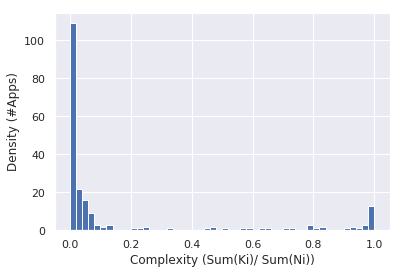

In [62]:
fig, ax = plt.subplots()
ax.set_xlabel("Complexity (Sum(Ki)/ Sum(Ni))")
ax.set_ylabel("Density (#Apps)")
_ = plt.hist(optimals["complexityV"] , bins=50)

It is very clear in this Figure that there is two major groups of simple, and more complex applications.
To move forward with this result, let's look at figure X where instead of relative complexity we look at there absolute values sum(Ki) vs sum(Ni).


In [63]:
counted = optimals.groupby("filename").count()
print("Number of Graph where optimality is reached the first round:", len(counted[ counted[ "sum_Ki" ] == 1]) ,"over" , len(counted))

Number of Graph where optimality is reached the first round: 201 over 203


Second the disstribution of the maximum complexity required to rach optimality. There is clearly two groups of application, these that reach otpimality within less than 10% of the final complexity and for which the algoritmh provide the best result, and other, more complex problem, where  80% or more of compleixty is reach.
To move forward with this result, let's look at figure X where instead of relative complexity we look at there absolute complexity (sum(Ni)).

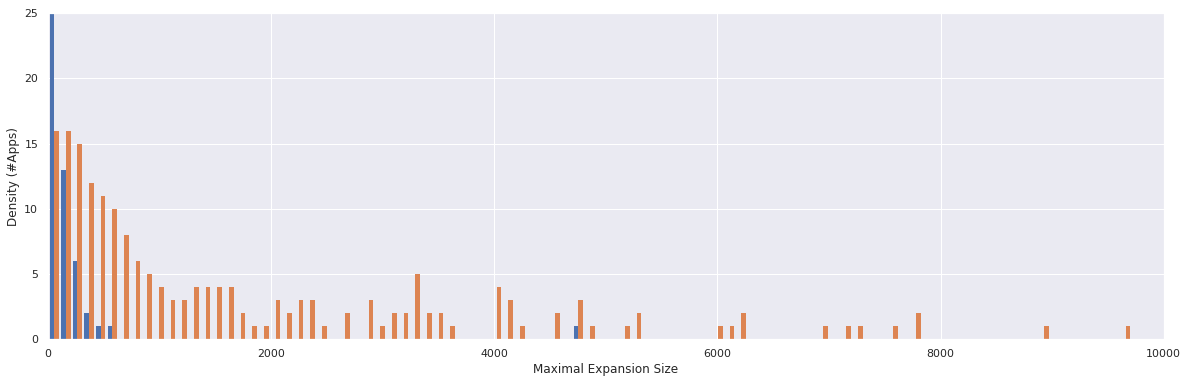

In [64]:
import numpy as np
hardoptimals = optimals
f, axs = plt.subplots(1,1,figsize=(20,6))
axs.set_xlabel("Maximal Expansion Size")
axs.set_ylabel("Density (#Apps)")
_ = plt.hist( [ hardoptimals["sum_Ki"], (hardoptimals["sum_Ni"]) ] , bins = 2000, linewidth=0)
_ = axs.set_ylim(0,25)
_ = axs.set_xlim(0,10000)
## /!\ Note the first line cute and the missing point in the far right 

### GARDER THIS ONE  (5)

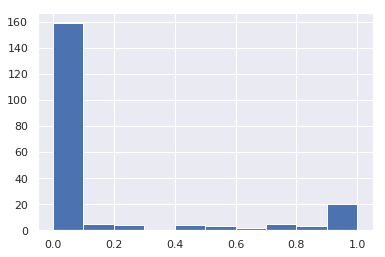

In [65]:
hardoptimals["maxComplexityV"].hist()

In this graph it is even more clear that the Algorithm dramatically reduce the computation complexity, as we see the size of the schedule generated are all less than 400 starting times, while more classic approach would have require up to thousands of starting time for several applications.   

Finally, we analysed the graph amount those which no optimal solution is reach at the first stage, and look for the different intermediate reprensetations (that were not optimal).
We can see there is a lot of disparity in these result, and not sure we can tak advantage of that in the future, this is really case by case. 

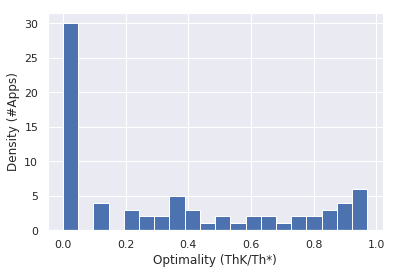

In [66]:
import numpy as np

f, axs = plt.subplots(1,1)
axs.set_xlabel("Optimality (ThK/Th*)")
axs.set_ylabel("Density (#Apps)")

temp = iter_df[iter_df ["th"] !=  iter_df["maxth"] ]
#f, axs = plt.subplots(1,1,figsize=(20,6))
_ = plt.hist( [ temp["th"] / temp["maxth"]] , bins = 20)
#axs.set_ylim(0,25)
#axs.set_xlim(0,10000)

# Selected figures for the paper 

## Iteration distribution

/home/toky/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


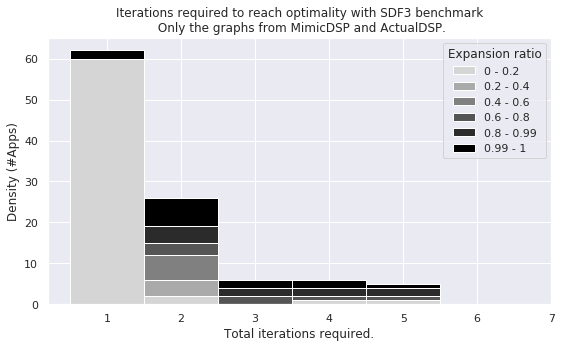

In [67]:
fig, axs = plt.subplots(1,1)
fig.set_size_inches(8, 5)
sections = [0.2,0.4,0.6,0.8,0.99]
_ = plot_iteration_distribution (axs,graph_df [ (graph_df["categoryStr"] != "three") & (graph_df["categoryStr"] != "four") ],
                                 sections,"Iterations required to reach optimality with SDF3 benchmark\n Only the graphs from MimicDSP and ActualDSP.") 


fig.tight_layout()


plt.savefig("iteration_distribution.png")

## Execution time Vs Task graph

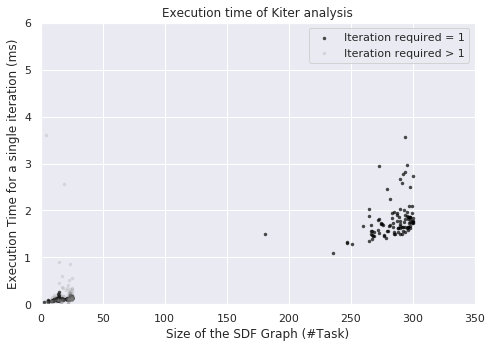

In [68]:
import matplotlib.pyplot as plt
import numpy as np 
import matplotlib.style
import matplotlib as mpl
import seaborn as sns
sns.set()

fig, ax = plt.subplots(1,1)
fig.set_size_inches(7, 5)

tmp = clean_iter_df
tmpE = tmp[tmp["difficult"] == False]
tmpH = tmp[tmp["difficult"] == True]


ax.set_title("Execution time of Kiter analysis")
ax.scatter(tmpE["task_count"], tmpE["duration"] * 1000, s=12,  label = "Iteration required = 1" ,  linewidths = 0, color = "black", alpha=0.7 )
ax.scatter(tmpH["task_count"], tmpH["duration"] * 1000, s=12,  label = "Iteration required > 1", linewidths = 0, color = "grey", alpha=0.2)
ax.set_ylim(0,6)
ax.set_xlim(0,350)
ax.legend()
ax.set_ylabel('Execution Time for a single iteration (ms)')
ax.set_xlabel('Size of the SDF Graph (#Task)')

fig.tight_layout()

plt.savefig("execution_graphsize.png")


## Complexity diagram

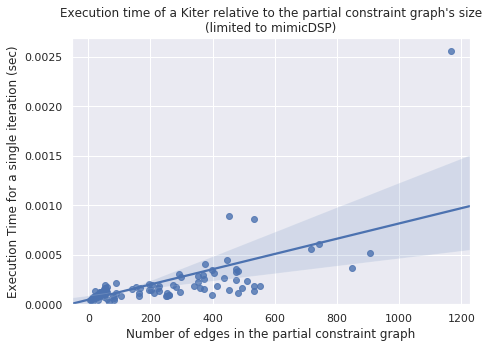

In [69]:

fig, ax = plt.subplots(1,1)
fig.set_size_inches(7, 5)
#_ = sns.regplot(data=iter_df[iter_df["categoryStr"] == "one"], x='sum_KiKj', y='duration',  fit_reg=True)
_ = sns.regplot(data=iter_df[iter_df["categoryStr"] == "two"], x='sum_KiKj', y='duration',  fit_reg=True)

ax.set_ylim(0,None)
ax.set_title("Execution time of a Kiter relative to the partial constraint graph's size\n(limited to mimicDSP)")
ax.set_ylabel('Execution Time for a single iteration (sec)')
ax.set_xlabel('Number of edges in the partial constraint graph')

fig.tight_layout()


plt.savefig("complexity.png")


## All iteration path

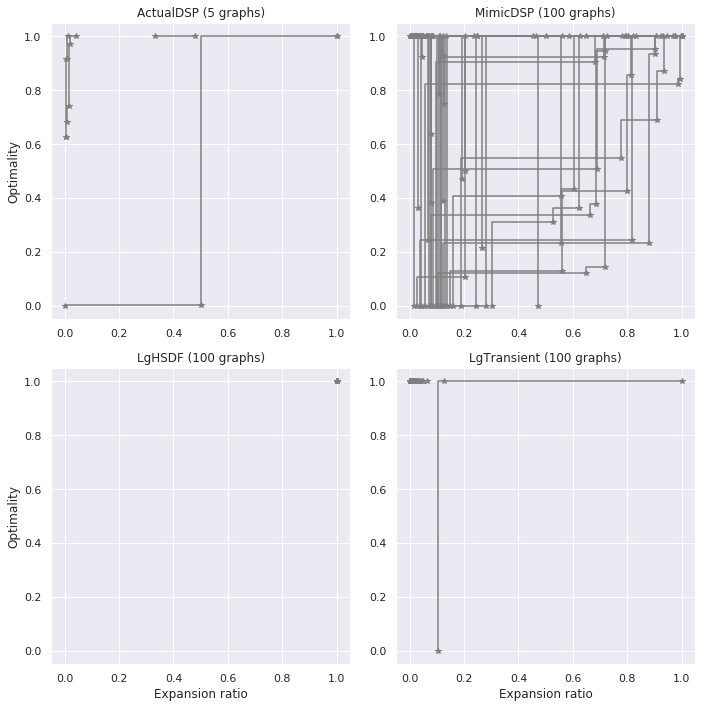

In [70]:
tmp = iter_df.copy()

fig, ax = plt.subplots(2,2)
fig.set_size_inches(10, 10)

plotIterationLines (ax[0,0],tmp[tmp["categoryStr"] == "one"],  "ActualDSP")
plotIterationLines (ax[0,1],tmp[tmp["categoryStr"] == "two"],  "MimicDSP")
plotIterationLines (ax[1,0],tmp[tmp["categoryStr"] == "three"],"LgHSDF")
plotIterationLines (ax[1,1],tmp[tmp["categoryStr"] == "four"], "LgTransient")


ax[0,0].set_xlabel(None)
ax[0,1].set_xlabel(None)
ax[0,1].set_ylabel(None)
ax[1,1].set_ylabel(None)

fig.tight_layout()


plt.savefig("iteration_optimality.png")

## Distribution of graph per expansion ratio

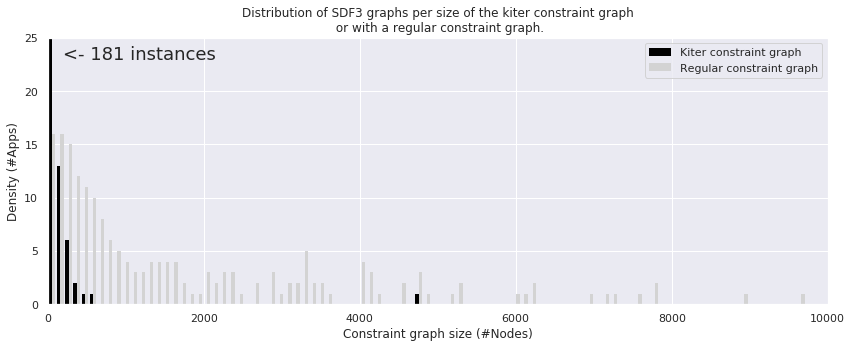

In [71]:
import numpy as np
hardoptimals = optimals
fig, axs = plt.subplots(1,1,figsize=(12,5))
axs.set_xlabel("Constraint graph size (#Nodes)")
axs.set_ylabel("Density (#Apps)")
hist = plt.hist( [ hardoptimals["sum_Ki"], (hardoptimals["sum_Ni"]) ] , bins = 2000, linewidth=0,
            label=["Kiter constraint graph","Regular constraint graph"] ,
             color=["black","lightgrey"])
_ = axs.set_ylim(0,25)
_ = axs.set_xlim(0,10000)
## /!\ Note the first line cute and the missing point in the far right 

### GARDER THIS ONE  (5)

axs.set_title("Distribution of SDF3 graphs per size of the kiter constraint graph\n or with a regular constraint graph.")
axs.legend()


plt.text(200,23, "<- 181 instances", size=18, va="baseline", ha="left")


fig.tight_layout()


plt.savefig("distribution_expansionsize.png")

In [72]:
tmp = graph_df[graph_df["categoryStr"] == "four"]
tmp = tmp[tmp["iteration"] > 1 ]
tmp

,filename,duration,th,complexityV,sum_Ki,sum_KiKj,sum_Ni,task_count,buffer_count,iteration,categoryStr
29,../benchmarks/sdf3bench//four_graph.35.xml,0.000232,0.013514,1.0,87,157,87,9,12,2,four
